# Census income
## Budowa modeli

## 1. Importowanie danych

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from matplotlib import pyplot as plt
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import svm

Skorzystamy z danych po pre-processingu wykonanego w pliku **01_EDA.ipynb**.

In [15]:
data = pd.read_csv ('census_income_dataset_processed.csv')
data = data.drop('Unnamed: 0', axis=1)
data

,income_level,age,workclass,education_num,sex,capital_gain,capital_loss,hours_per_week,race_Black,race_White,race_other,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,native_country_Mexico,native_country_United-States,native_country_other
0,0,39,6,13,1,2174.0,0.0,40.0,False,True,False,False,True,False,False,False,False,False,True,False
1,0,50,5,13,1,0.0,0.0,13.0,False,True,False,True,False,False,False,False,False,False,True,False
2,0,38,3,9,1,0.0,0.0,40.0,False,True,False,False,True,False,False,False,False,False,True,False
3,0,53,3,7,1,0.0,0.0,40.0,True,False,False,True,False,False,False,False,False,False,True,False
4,0,28,3,13,0,0.0,0.0,40.0,True,False,False,False,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,0,39,3,13,0,0.0,0.0,36.0,False,True,False,False,True,False,False,False,False,False,True,False
48838,0,64,3,9,1,0.0,0.0,40.0,True,False,False,False,False,True,False,False,False,False,True,False
48839,0,38,3,13,1,0.0,0.0,50.0,False,True,False,True,False,False,False,False,False,False,True,False
48840,0,44,3,13,1,5455.0,0.0,40.0,False,False,True,False,False,False,True,False,False,False,True,False


## 2. Podział danych

In [ ]:
y = data["income_level"]
X = data.drop("income_level", axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=420, train_size=0.7)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  random_state=420, train_size=0.7)

## 3. Tworzenie modeli

Jako miary skuteczności modeli postanowliśmy wybrać:
* accuracy
* recall i precision
* f1-score
* gini

Oprócz tego, wyniki będą zaprezentowane na krzywej ROC oraz na macierzy Confusiion Matrix.

Metryki:

In [18]:
def metrics_scores(model, X_train, y_train):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    f1 = f1_score(y_test, y_pred)

    roc_auc = roc_auc_score(y_test, y_pred)
    gini = (2*roc_auc)-1

    print("Accuracy:", accuracy,
          "\nRecall:", recall,
          "\nPrecision:", precision,
          "\nF1:", f1,
          "\nGini:", gini)

Reprezentacja Confusion Matrx dla danych treningowych i testowych:

In [ ]:
def plot_cm(model, X_train, X_test, y_train, y_test):
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    fig, axs = plt.subplots(ncols=2)
    cm = ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred_train))
    cm.plot(colorbar=False, ax=axs[0])
    axs[0].set_title("Train")
    
    cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test))
    cm.plot(colorbar=False, ax=axs[1])
    axs[1].set_title("Test")
    plt.show()

Przetestowaliśmy kilka modeli:
* SVC
* Random Forest
* XGBoost
* Logistic Regression

W poprzedniej wersji analizowaliśmy rówież model Dummy Classifier, ale okazał się najmniej skuteczny, zatem już nie będziemy się nim zajmować.

##### SVC

In [ ]:
clf = svm.SVC()
metrics_scores(clf, X_train, y_train)

Accuracy: 0.8007234013512591 
Recall: 0.27462602314422807 
Precision: 0.7354497354497355 
F1: 0.39991779695848745 
Gini: 0.24312287282919653


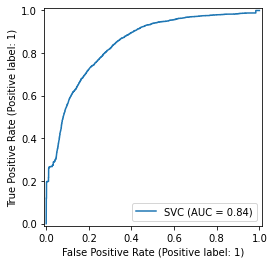

In [21]:
RocCurveDisplay.from_estimator(clf, X_test, y_test)

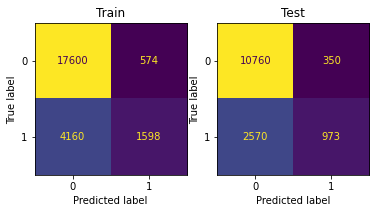

In [22]:
plot_cm(clf, X_train, X_test, y_train, y_test)

##### Random Forest

In [ ]:
rf = RandomForestClassifier()
metrics_scores(rf, X_train, y_train)

Accuracy: 0.84283081962738 
Recall: 0.6099350832627717 
Precision: 0.7011680726800779 
F1: 0.652377358490566 
Gini: 0.5270367934337887


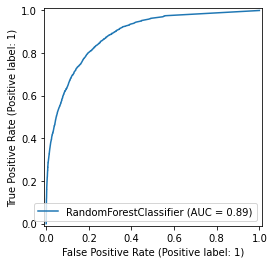

In [24]:
RocCurveDisplay.from_estimator(rf, X_test, y_test)

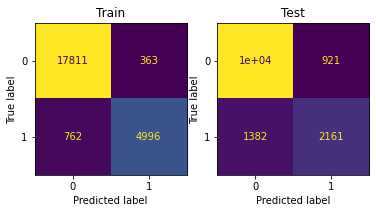

In [25]:
plot_cm(rf, X_train, X_test, y_train, y_test)

##### XGBoost

In [ ]:
# xgb = XGBClassifier(objective="binary:logistic", seed = 42, use_label_encoder=False)
xgb = XGBClassifier()
metrics_scores(xgb, X_train, y_train)

Accuracy: 0.8625537432607657 
Recall: 0.6291278577476714 
Precision: 0.7610105838170024 
F1: 0.6888133498145859 
Gini: 0.5661215571176086


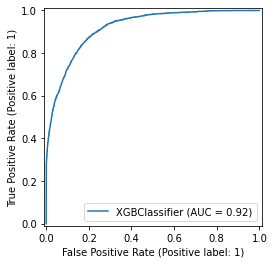

In [27]:
RocCurveDisplay.from_estimator(xgb, X_test, y_test)

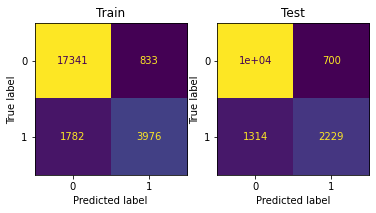

In [28]:
plot_cm(xgb, X_train, X_test, y_train, y_test)

##### Logisitc Regression

In [ ]:
# LR_model = LogisticRegression(random_state=420,n_jobs=-1)
LR_model = LogisticRegression()
metrics_scores(LR_model, X_train, y_train)

Accuracy: 0.81628335494438 
Recall: 0.4792548687552921 
Precision: 0.6671905697445972 
F1: 0.5578186596583443 
Gini: 0.40301724499291613


C:\Users\mipec\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


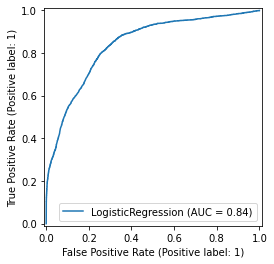

In [30]:
RocCurveDisplay.from_estimator(LR_model, X_test, y_test)

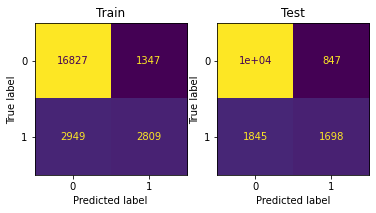

In [31]:
plot_cm(LR_model, X_train, X_test, y_train, y_test)

Spośród wybranych klasyfikatorów, na razie najlepiej wypadły **Random Forest** i **XGBoost**. Teraz spróbujemy dobrać ich hiperparametry w celu ulepszenia tych modeli oraz wyboru ostatecznego modelu.

## 4. Strojenie hiperparanetrów
W celu doboru odpowiednich hiperparametrów skorzystamy z **Grid Search'a**, aby optymalizować te wartości.

##### Random Forest - hiperparametry

In [33]:
search_space = {"max_depth": [None, 2, 4, 8, 10],
               "n_estimators": [10,20,50,100],
               "class_weight": [None, "balanced", "balanced_subsample"]}

In [34]:
rf2 = RandomForestClassifier()

In [35]:
gscv = GridSearchCV(rf2, search_space, scoring="recall", verbose = 2, n_jobs=-1)

In [36]:
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced',
                                          'balanced_subsample'],
                         'max_depth': [None, 2, 4, 8, 10],
                         'n_estimators': [10, 20, 50, 100]},
             scoring='recall', verbose=2)

In [37]:
gscv.best_params_

{'class_weight': 'balanced_subsample', 'max_depth': 8, 'n_estimators': 100}

In [38]:
# rf2_best_estimator = gscv.best_estimator_
rf_best_estimator = RandomForestClassifier(class_weight='balanced',
                                           max_depth=8, n_estimators=100)

Porównanie wyników przed i po doborze hiperparametrów:

In [39]:
metrics_scores(rf, X_train, y_train)

Accuracy: 0.8413976660069611 
Recall: 0.6121930567315834 
Precision: 0.6954151971785829 
F1: 0.6511558090663464 
Gini: 0.526684505876498


In [40]:
metrics_scores(rf_best_estimator, X_train, y_train)

Accuracy: 0.7969699037739713 
Recall: 0.8791984194185718 
Precision: 0.5501589544330625 
F1: 0.6768060836501901 
Gini: 0.6499454941260425


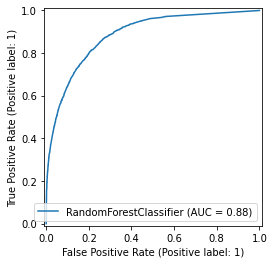

In [41]:
RocCurveDisplay.from_estimator(rf, X_test, y_test)

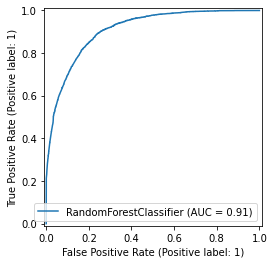

In [42]:
RocCurveDisplay.from_estimator(rf_best_estimator, X_test, y_test)

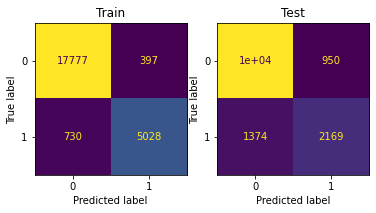

In [43]:
plot_cm(rf, X_train, X_test, y_train, y_test)

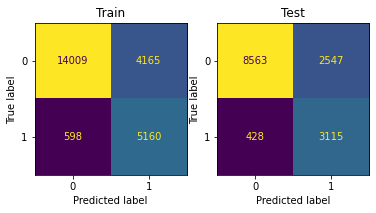

In [44]:
plot_cm(rf_best_estimator, X_train, X_test, y_train, y_test)

Strojenie hiperparametrów dało nam wynik AUC większy o 0.01 oraz widać po macierzach, iż zmiany te ulepszyły model. 

##### XGBoost - hiperparametry

In [45]:
search_space = {"max_depth": [None, 2, 4, 8, 10],
               "n_estimators": [10,20,50,100],
               "loss": [None, "deviance", "exponential"]}

In [46]:
xgb2 = XGBClassifier()

In [47]:
gscv = GridSearchCV(xgb2, search_space, scoring="recall", verbose = 2, n_jobs=-1)

In [48]:
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'loss': [None, 'deviance', 'exponential'],
                         'max_depth': [None, 2, 4, 8, 10],
                         'n_estimators': [10, 20, 50, 100]},
             scoring='recall', verbose=2)

In [49]:
gscv.best_params_

{'loss': None, 'max_depth': None, 'n_estimators': 100}

In [50]:
xgb_best_estimator = XGBClassifier(loss=None,
                                   max_depth=8, n_estimators=100)

In [51]:
metrics_scores(xgb, X_train, y_train)

Accuracy: 0.8625537432607657 
Recall: 0.6291278577476714 
Precision: 0.7610105838170024 
F1: 0.6888133498145859 
Gini: 0.5661215571176086


In [52]:
metrics_scores(xgb_best_estimator, X_train, y_train)

Accuracy: 0.8625537432607657 
Recall: 0.6313858312164832 
Precision: 0.7595925297113753 
F1: 0.6895807644882861 
Gini: 0.5676594585792192


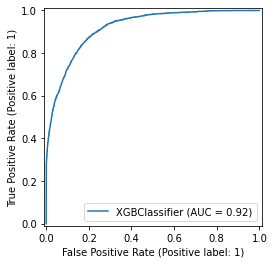

In [53]:
RocCurveDisplay.from_estimator(xgb, X_test, y_test)

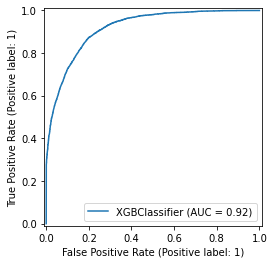

In [54]:
RocCurveDisplay.from_estimator(xgb_best_estimator, X_test, y_test)

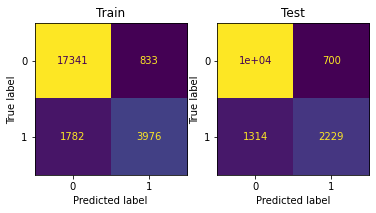

In [55]:
plot_cm(xgb, X_train, X_test, y_train, y_test)

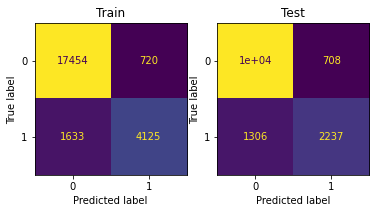

In [56]:
plot_cm(xgb_best_estimator, X_train, X_test, y_train, y_test)

W tym wypadku trojenie parametrów niewiele wniosło do naszego modelu.

##### Logisitc Regression - hiperparametry

In [57]:
search_space = {"penalty": [None, 'l1', 'l2', 'elasticnet'],
               "class_weight": ['dict', 'balanced'],
               "max_iter": [10,50,100,200]}

In [58]:
LR_model2 = LogisticRegression()

In [59]:
gscv = GridSearchCV(LR_model2, search_space, scoring="recall", verbose = 2, n_jobs=-1)

In [60]:
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


C:\Users\mipec\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
120 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mipec\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mipec\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-pa

GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'class_weight': ['dict', 'balanced'],
                         'max_iter': [10, 50, 100, 200],
                         'penalty': [None, 'l1', 'l2', 'elasticnet']},
             scoring='recall', verbose=2)

In [61]:
gscv.best_params_

{'class_weight': 'balanced', 'max_iter': 200, 'penalty': 'l2'}

In [62]:
LR_model_best_estimator = LogisticRegression(
    class_weight='balanced', max_iter=200, penalty='l2')

In [63]:
metrics_scores(LR_model, X_train, y_train)

C:\Users\mipec\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.81628335494438 
Recall: 0.4792548687552921 
Precision: 0.6671905697445972 
F1: 0.5578186596583443 
Gini: 0.40301724499291613


In [64]:
metrics_scores(LR_model_best_estimator, X_train, y_train)

Accuracy: 0.7752678632361973 
Recall: 0.8060965283657917 
Precision: 0.522885389967045 
F1: 0.6343142698500833 
Gini: 0.571533072020157


C:\Users\mipec\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


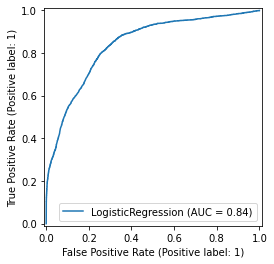

In [65]:
RocCurveDisplay.from_estimator(LR_model, X_test, y_test)

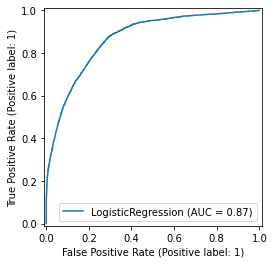

In [66]:
RocCurveDisplay.from_estimator(LR_model_best_estimator, X_test, y_test)

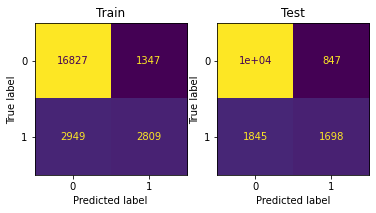

In [67]:
plot_cm(LR_model, X_train, X_test, y_train, y_test)

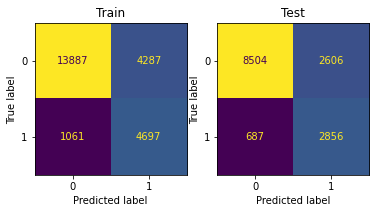

In [68]:
plot_cm(LR_model_best_estimator, X_train, X_test, y_train, y_test)

Tu również widzimy poprawę w działaniu modelu, jednak nie jest to jeszcze zadowalający wynik. 

Zatem najlepiej wypadły modele RandomForest oraz XGBoost.

## 5. Interpretowalność

##### Logisitc Regression

In [74]:
X_test = X_test.astype(float)

In [75]:
LR_model = LR_model_best_estimator

In [76]:
explainer = shap.Explainer(LR_model_best_estimator.predict, X_test)
shap_values = explainer(X_test)

PermutationExplainer explainer: 14654it [04:37, 51.47it/s]                           


In [77]:
X_val.columns

Index(['age', 'workclass', 'education_num', 'sex', 'capital_gain',
       'capital_loss', 'hours_per_week', 'race_Black', 'race_White',
       'race_other', 'relationship_Husband', 'relationship_Not-in-family',
       'relationship_Other-relative', 'relationship_Own-child',
       'relationship_Unmarried', 'relationship_Wife', 'native_country_Mexico',
       'native_country_United-States', 'native_country_other'],
      dtype='object')

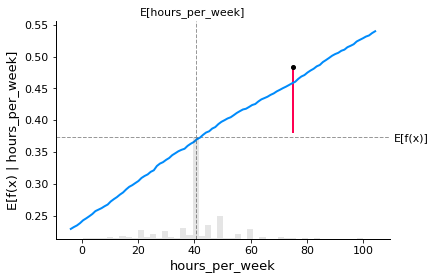

In [78]:
sample_ind = 1
plot = shap.partial_dependence_plot(
'hours_per_week', LR_model_best_estimator.predict, X_val, model_expected_value=True,
feature_expected_value=True, ice=False,
shap_values=shap_values[sample_ind:sample_ind+1,:]
)

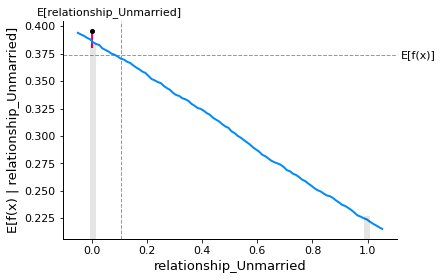

In [82]:
sample_ind = 1
plot = shap.partial_dependence_plot(
'relationship_Unmarried', LR_model_best_estimator.predict, X_val, model_expected_value=True,
feature_expected_value=True, ice=False,
shap_values=shap_values[sample_ind:sample_ind+1,:]
)

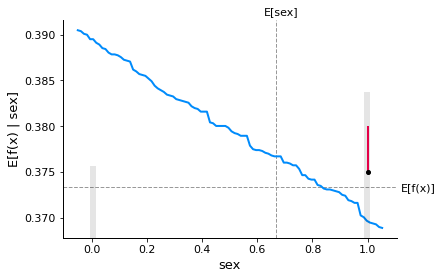

In [83]:
sample_ind = 1
plot = shap.partial_dependence_plot(
'sex', LR_model_best_estimator.predict, X_val, model_expected_value=True,
feature_expected_value=True, ice=False,
shap_values=shap_values[sample_ind:sample_ind+1,:]
)

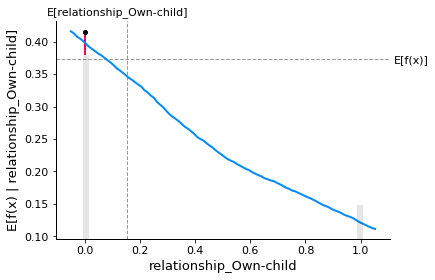

In [84]:
sample_ind = 1
plot = shap.partial_dependence_plot(
'relationship_Own-child', LR_model_best_estimator.predict, X_val, model_expected_value=True,
feature_expected_value=True, ice=False,
shap_values=shap_values[sample_ind:sample_ind+1,:]
)

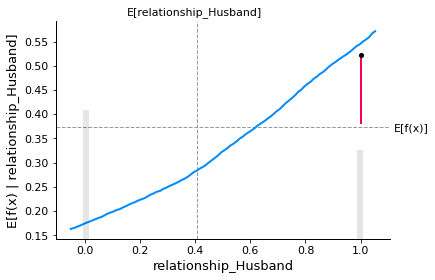

In [85]:
sample_ind = 1
plot = shap.partial_dependence_plot(
'relationship_Husband', LR_model_best_estimator.predict, X_val, model_expected_value=True,
feature_expected_value=True, ice=False,
shap_values=shap_values[sample_ind:sample_ind+1,:]
)

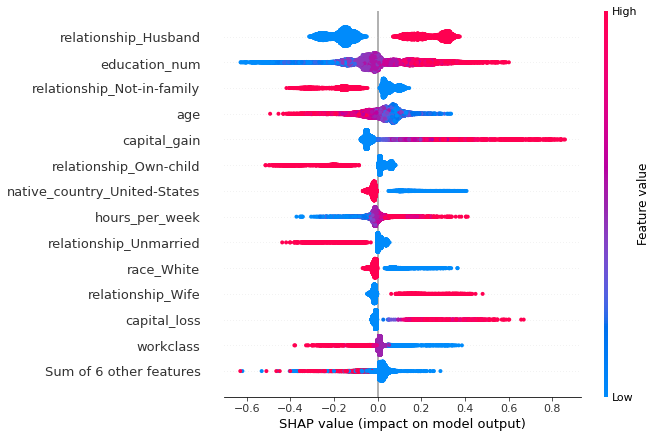

In [86]:
shap.plots.beeswarm(shap_values, max_display=14)

##### Random Forest

In [116]:
shap_values[0, :, 1]

array([-1.04119741e-02, -2.76981182e-03, -1.01243218e-01, -2.88254873e-02,
       -1.55241561e-02, -1.90655967e-03,  3.76616944e-02,  8.77801687e-04,
        1.35154756e-03, -1.42387139e-05, -7.23117495e-02, -4.23502456e-02,
        5.07873963e-04,  7.75133083e-03,  5.70357075e-03, -1.04197673e-02,
        1.51525941e-03,  6.45393477e-04, -1.21785229e-04])

In [117]:
explainer = shap.TreeExplainer(rf_best_estimator, X_val)
sample = X_val.iloc[[420]]
shap_values = explainer.shap_values(sample)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[0, :, 1], sample)

In [118]:
explainer = shap.TreeExplainer(rf_best_estimator, X_val)
sample = X_val.iloc[[25]]
shap_values = explainer.shap_values(sample)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[0, :, 1], sample)

In [119]:
explainer = shap.TreeExplainer(rf_best_estimator, X_val)
sample = X_val.iloc[[122]]
shap_values = explainer.shap_values(sample)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[0, :, 1], sample)

In [120]:
explainer = shap.TreeExplainer(rf_best_estimator, X_val)
sample = X_val.iloc[[400]]
shap_values = explainer.shap_values(sample)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[0, :, 1], sample)